## Import libraries

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import ETFs as etfs

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers


Total number of ETFs: 33


## Read CSV

In [13]:
data = pd.read_csv('../../dataProcessing/assets_filled.csv', parse_dates=['Date'])
print(data.columns.tolist())
data.set_index('Date', inplace=True)
display(data)


['Date', 'AIEQ', 'ASHR.L', 'BCHN.L', 'CORN', 'DBO', 'EDEN', 'EMXC', 'EWA', 'EWC', 'EWG', 'EWH', 'EWJ', 'EWQ', 'EWS', 'EWU', 'EWW', 'GLD', 'IDUP.L', 'IEMG', 'INDA', 'KSA', 'PSCC', 'SEMI.AS', 'SLV', 'SPY', 'TLT', 'USO', 'VDE', 'VDNR.L', 'VGK', 'VNQ', 'VPL', 'XMAF.L']


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,21.902443,6.246624,40.000000,42.619999,26.042212,22.380077,42.757008,12.307330,20.625574,14.720881,...,28.830000,100.450684,83.888573,317.519989,69.905655,42.300957,27.664722,34.591938,33.707809,6.78375
2012-01-04,21.902443,6.246624,40.000000,42.509998,26.165096,22.380077,42.757008,12.452251,20.587934,14.581520,...,28.389999,100.608261,82.891136,318.160004,70.114944,42.300957,27.328695,34.000530,33.888020,6.69750
2012-01-05,21.902443,6.246624,40.000000,41.509998,25.814005,22.380077,42.757008,12.290605,20.459967,14.412823,...,28.510000,100.876129,82.743668,313.359985,69.817871,42.300957,26.831099,34.319885,33.472149,6.68250
2012-01-06,21.902443,6.246624,40.000000,41.349998,25.919331,22.380077,42.757008,12.128960,20.249193,14.148770,...,27.910000,100.616127,83.396919,313.760010,69.392532,42.300957,26.462753,34.207520,33.070118,6.72625
2012-01-09,21.902443,6.246624,40.000000,42.189999,25.831558,22.380077,42.757008,12.167979,20.309414,14.207450,...,28.129999,100.860359,83.249390,312.640015,69.655830,42.300957,26.663073,34.089233,33.097832,6.69625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.276001,10.405000,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440000,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875
2025-03-26,37.854000,10.400000,98.169998,18.559999,14.110000,105.839996,56.080002,23.709999,41.380001,37.560001,...,30.530001,568.590027,88.196609,75.419998,130.250000,139.595001,71.139999,90.059998,74.410004,8.14500


In [19]:
first_prices = data.iloc[:1]
first_prices.values

array([[ 21.90244293,   6.24662399,  40.        ,  42.61999893,
         26.04221153,  22.38007736,  42.7570076 ,  12.30733013,
         20.62557411,  14.72088146,  10.45192623,  30.00427818,
         14.19258881,  13.14745522,  19.75927925,  41.37704086,
        155.91999817,  13.62710571,  35.37962341,  23.19848824,
         20.75997353,   8.67868042,   5.19500017,  28.82999992,
        100.45068359,  83.88857269, 317.51998901,  69.90565491,
         42.30095673,  27.66472244,  34.59193802,  33.70780945,
          6.78375006]])

In [26]:
normalized_data = data.copy()
normalized_data = data / first_prices.values
normalized_data

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2012-01-04,1.000000,1.000000,1.000000,0.997419,1.004719,1.000000,1.000000,1.011775,0.998175,0.990533,...,0.984738,1.001569,0.988110,1.002016,1.002994,1.000000,0.987854,0.982903,1.005346,0.987286
2012-01-05,1.000000,1.000000,1.000000,0.973956,0.991237,1.000000,1.000000,0.998641,0.991971,0.979073,...,0.988900,1.004235,0.986352,0.986898,0.998744,1.000000,0.969867,0.992135,0.993009,0.985075
2012-01-06,1.000000,1.000000,1.000000,0.970202,0.995281,1.000000,1.000000,0.985507,0.981752,0.961136,...,0.968089,1.001647,0.994139,0.988158,0.992660,1.000000,0.956552,0.988887,0.981082,0.991524
2012-01-09,1.000000,1.000000,1.000000,0.989911,0.991911,1.000000,1.000000,0.988677,0.984671,0.965122,...,0.975720,1.004078,0.992381,0.984631,0.996426,1.000000,0.963793,0.985468,0.981904,0.987102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1.747568,1.665700,2.513750,0.444158,0.542965,4.822593,1.321187,1.925682,2.012550,2.583405,...,1.039195,5.715043,1.058428,0.235828,1.845788,3.316001,2.592833,2.622808,2.215807,1.221669
2025-03-25,1.752316,1.671303,2.518000,0.440404,0.538741,4.795783,1.323292,1.934619,2.022247,2.607181,...,1.060701,5.728782,1.058311,0.235639,1.851925,3.320965,2.608376,2.593379,2.227674,1.201216
2025-03-26,1.728300,1.664899,2.454250,0.435476,0.541813,4.729206,1.311598,1.926494,2.006247,2.551478,...,1.058966,5.660390,1.051354,0.237528,1.863226,3.300044,2.571506,2.603497,2.207500,1.200663


In [27]:
print(f"normalized_size = {data.shape}")
def create_X_y(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X_window = df.iloc[i : i + window_size].values
        y_target = df.iloc[i + window_size].values
        X.append(X_window)
        y.append(y_target)
    X = np.array(X)
    y = np.array(y)
    return X, y
window_size = 30
X, y = create_X_y(normalized_data, window_size)
print(X.shape)
print(y.shape)


normalized_size = (3408, 33)
(3378, 30, 33)
(3378, 33)


## Train the model

In [28]:
dataset_size = len(X)
print(dataset_size)


train_size = int(dataset_size * 0.8)
test_size =int(dataset_size * 0.1)
val_size = dataset_size - train_size - test_size


X_train, X_val, X_test = X[:train_size], X[train_size: train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test= y[:train_size], y[train_size: train_size + val_size], y[train_size + val_size:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


3378


((2702, 30, 33),
 (2702, 33),
 (339, 30, 33),
 (339, 33),
 (337, 30, 33),
 (337, 33))

In [29]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),  
    LSTM(64, return_sequences=False),  
    Dense(y_train.shape[1])  
])

cp = ModelCheckpoint(filepath='model/best_first.keras', save_best_only=True, monitor='val_loss', mode='min')

model.compile(loss=MeanSquaredError(), 
              optimizer=Adam(learning_rate=0.001), 
              metrics=[MeanSquaredError()])

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[cp]
)
# model.summary()



c:\Users\Shelly\Desktop\BachelorProject\BAvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - loss: 0.8138 - mean_squared_error: 0.8136 - val_loss: 0.3798 - val_mean_squared_error: 0.3919
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.1107 - mean_squared_error: 0.1107 - val_loss: 0.1425 - val_mean_squared_error: 0.1488
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - loss: 0.0281 - mean_squared_error: 0.0281 - val_loss: 0.0892 - val_mean_squared_error: 0.0905
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0793 - val_mean_squared_error: 0.0811
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0707 - val_mean_squared_error: 0.0729
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0687 - val_mean_squared_error: 0.0709
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.

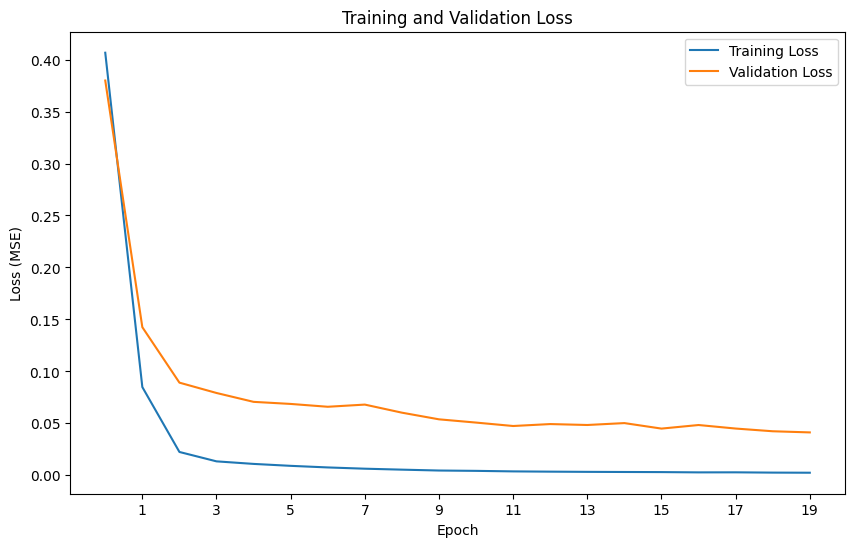

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_squared_error'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
xticks = np.arange(1, 21, 2)
plt.xticks(xticks)
plt.title('Training and Validation Loss')
plt.show()

## Predictions

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 598ms/step


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,32.509702,11.375472,75.811810,24.817806,16.651011,87.330129,50.820615,21.027747,35.331858,24.072660,...,18.768214,391.364356,104.504765,95.196924,103.552755,96.359708,52.564558,90.682370,64.011329,7.898575
2023-12-08,32.555128,11.403862,76.062126,24.833086,16.677288,87.402376,50.853226,21.050482,35.364036,24.095727,...,18.854964,391.827703,104.823935,94.913493,103.543896,96.532329,52.588234,90.849833,64.011767,7.912236
2023-12-11,32.614426,11.428673,76.326060,24.851235,16.697054,87.494147,50.881876,21.073871,35.409444,24.127752,...,18.938446,392.313156,105.071212,94.839655,103.576363,96.711061,52.641742,90.998821,64.037829,7.929987
2023-12-12,32.666525,11.446982,76.542459,24.838314,16.711636,87.570903,50.904660,21.091530,35.438998,24.160889,...,18.995648,392.781820,105.310679,94.792265,103.571588,96.863521,52.684255,91.121064,64.064627,7.943641
2023-12-13,32.718640,11.461550,76.730995,24.831801,16.716801,87.646175,50.923820,21.102968,35.462976,24.191843,...,19.044151,393.227301,105.519305,94.640935,103.531038,96.982881,52.717653,91.217154,64.089524,7.952937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.186021,12.852954,102.800598,22.862877,14.574274,98.639898,57.620724,21.328997,37.490573,29.699683,...,21.655643,426.132742,115.449010,89.022350,93.464703,105.672163,61.472910,94.485063,69.868974,9.102396
2025-03-25,38.134922,12.834725,102.454653,22.827048,14.649231,98.508029,57.587043,21.334566,37.510725,29.650343,...,21.588620,425.896793,115.149822,89.857180,93.924015,105.568657,61.444891,94.448907,69.816624,9.119878
2025-03-26,38.075689,12.812871,102.078800,22.790871,14.722693,98.364089,57.544054,21.338017,37.526840,29.606496,...,21.520805,425.606623,114.835522,90.726880,94.371344,105.444819,61.416318,94.395340,69.773146,9.136400


<Axes: xlabel='Date'>

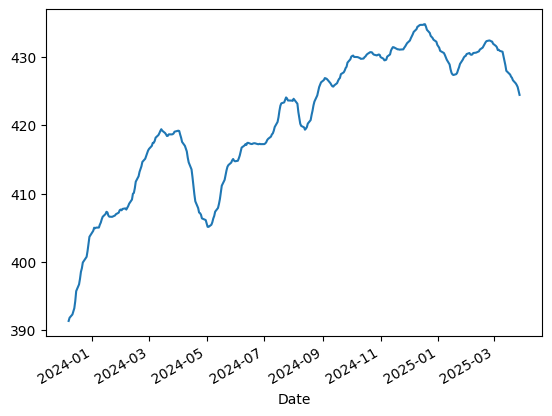

In [39]:
model = load_model('model/best_first.keras')
Y_pred = model.predict(X_test)

index_series = data.index[-len(y_test):]
Y_pred_denormalized = Y_pred * first_prices.values

Y_pred_df = pd.DataFrame(Y_pred_denormalized, index = index_series, columns = data.columns)

display(Y_pred_df)

Y_pred_df["SPY"].plot()



In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming y_test and y_pred are your actual and predicted values
mse = mean_squared_error(y_test, Y_pred)
mae = mean_absolute_error(y_test, Y_pred)
r2 = r2_score(y_test, Y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")


Mean Squared Error: 0.1553
Mean Absolute Error: 0.2760
R-squared: -7.9804


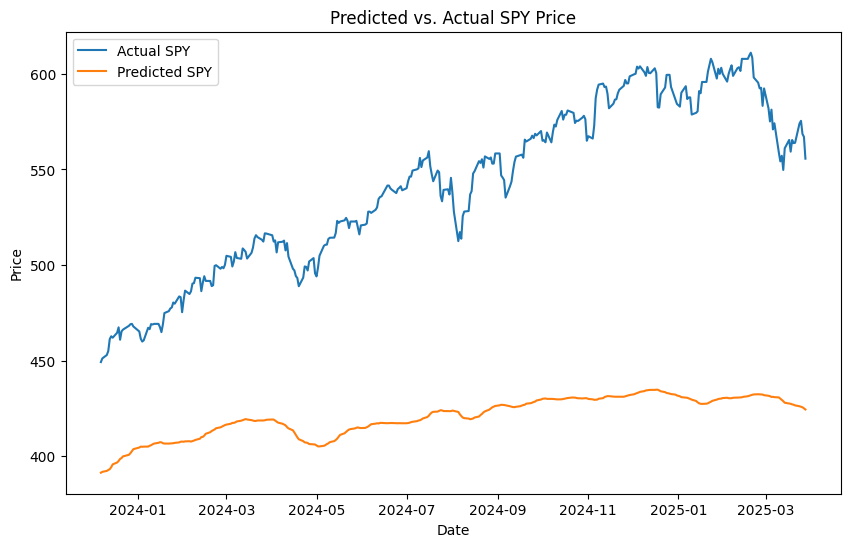

In [45]:
y_actual = pd.DataFrame(y_test * first_prices.values, index=index_series, columns=data.columns)

plt.figure(figsize=(10,6))
plt.plot(y_actual["SPY"], label='Actual SPY')
plt.plot(Y_pred_df["SPY"], label='Predicted SPY')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted vs. Actual SPY Price')
plt.legend()
plt.show()


In [46]:
print("Mean of actual normalized prices:", np.mean(y_test))
print("Mean of predicted normalized prices:", np.mean(Y_pred))


Mean of actual normalized prices: 1.991787477213212
Mean of predicted normalized prices: 1.8591474


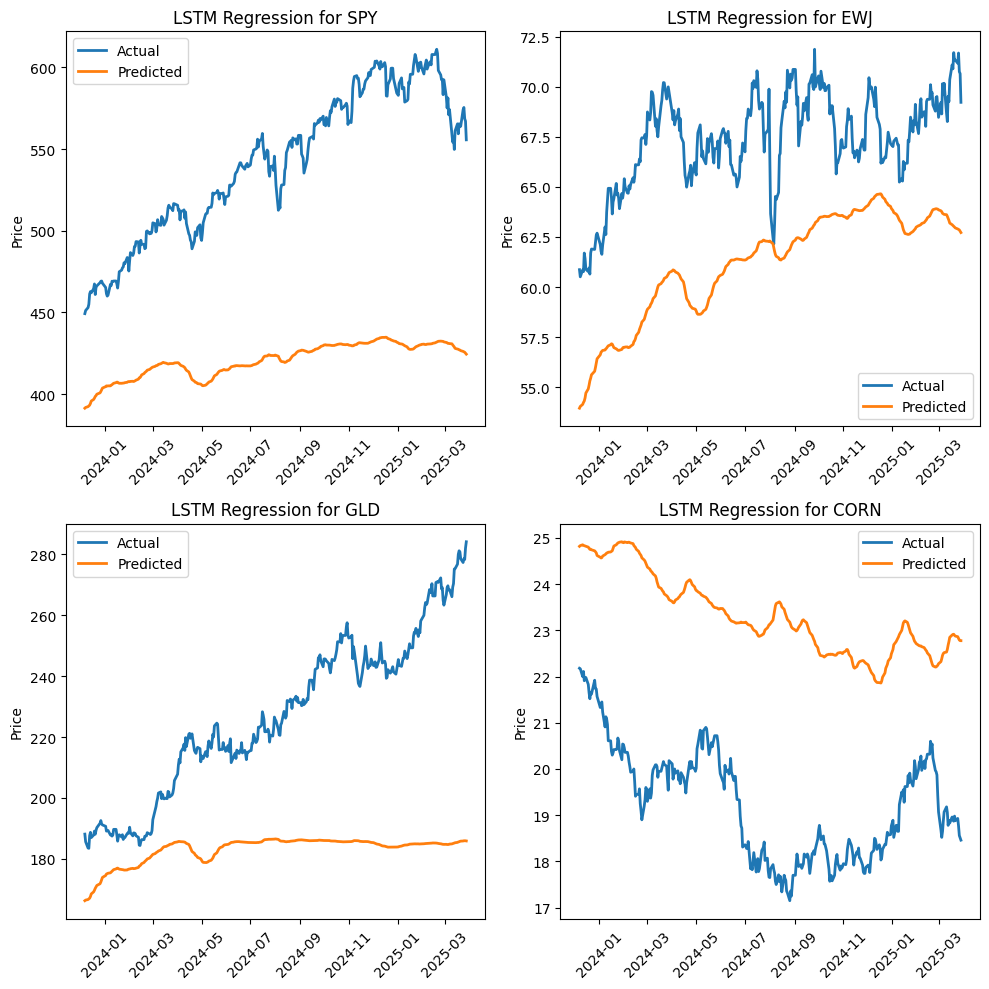

In [50]:
ticker_name = ['SPY', 'EWJ', 'GLD', 'CORN']  

num_plots = len(ticker_name)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
axes = axes.flatten() 


for i, ticker in enumerate(ticker_name):
    ax = axes[i]
    ax.plot(y_actual[ticker], label='Actual', linewidth=2)
    ax.plot(Y_pred_df[ticker], label='Predicted', linewidth=2)
    ax.set_title(f'LSTM Regression for {ticker}')
    ax.set_ylabel('Price')
    ax.tick_params(axis='x', rotation=45)

    ax.legend()

for j in range(len(ticker_name), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [51]:
label = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
label_test = label.iloc[-len(y_test):]
label_test.set_index('Date', inplace=True)
display(label_test)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,1,1,0,1,1,1,1,1,0,1,...,0,1,0,1,0,0,1,1,1,0
2023-12-08,1,0,1,0,1,0,0,1,1,1,...,0,1,0,1,1,1,1,0,0,0
2023-12-11,1,1,0,0,1,0,1,0,1,1,...,0,1,0,1,1,1,1,1,1,1
2023-12-12,0,0,1,1,0,0,0,1,0,1,...,0,1,1,0,0,1,1,0,1,0
2023-12-13,1,0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,0,1,1,1,0,...,0,1,0,1,1,1,0,1,1,0
2025-03-25,1,1,1,0,0,0,1,1,1,1,...,1,1,0,0,1,1,1,0,1,0
2025-03-26,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0


In [53]:
Y_pred_df

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,32.509702,11.375472,75.811810,24.817806,16.651011,87.330129,50.820615,21.027747,35.331858,24.072660,...,18.768214,391.364356,104.504765,95.196924,103.552755,96.359708,52.564558,90.682370,64.011329,7.898575
2023-12-08,32.555128,11.403862,76.062126,24.833086,16.677288,87.402376,50.853226,21.050482,35.364036,24.095727,...,18.854964,391.827703,104.823935,94.913493,103.543896,96.532329,52.588234,90.849833,64.011767,7.912236
2023-12-11,32.614426,11.428673,76.326060,24.851235,16.697054,87.494147,50.881876,21.073871,35.409444,24.127752,...,18.938446,392.313156,105.071212,94.839655,103.576363,96.711061,52.641742,90.998821,64.037829,7.929987
2023-12-12,32.666525,11.446982,76.542459,24.838314,16.711636,87.570903,50.904660,21.091530,35.438998,24.160889,...,18.995648,392.781820,105.310679,94.792265,103.571588,96.863521,52.684255,91.121064,64.064627,7.943641
2023-12-13,32.718640,11.461550,76.730995,24.831801,16.716801,87.646175,50.923820,21.102968,35.462976,24.191843,...,19.044151,393.227301,105.519305,94.640935,103.531038,96.982881,52.717653,91.217154,64.089524,7.952937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.186021,12.852954,102.800598,22.862877,14.574274,98.639898,57.620724,21.328997,37.490573,29.699683,...,21.655643,426.132742,115.449010,89.022350,93.464703,105.672163,61.472910,94.485063,69.868974,9.102396
2025-03-25,38.134922,12.834725,102.454653,22.827048,14.649231,98.508029,57.587043,21.334566,37.510725,29.650343,...,21.588620,425.896793,115.149822,89.857180,93.924015,105.568657,61.444891,94.448907,69.816624,9.119878
2025-03-26,38.075689,12.812871,102.078800,22.790871,14.722693,98.364089,57.544054,21.338017,37.526840,29.606496,...,21.520805,425.606623,114.835522,90.726880,94.371344,105.444819,61.416318,94.395340,69.773146,9.136400


In [ ]:
y_test_shift = data[train_size + val_size + window_size - 1: -1]
y_test_shift_index = data.index[train_size + val_size + window_size-1: -1]

y_test_shift_df = pd.DataFrame(y_test_shift, index=y_test_shift_index, columns=data.columns)
y_test_shift_array = y_test_shift_df.values


predicted_directions = (Y_pred_df > y_test_shift_array).astype(int)
predicted_directions_df = pd.DataFrame(predicted_directions, index=index_series, columns=data.columns)
display(predicted_directions_df)


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,1,1,0,1,1,0,1,0,1,0,...,0,0,1,1,0,0,0,1,0,1
2023-12-08,1,1,0,1,1,0,0,0,1,0,...,0,0,1,1,0,0,0,1,0,1
2023-12-11,1,1,0,1,1,0,0,0,1,0,...,0,0,1,1,0,0,0,1,0,1
2023-12-12,0,1,1,1,1,0,0,0,1,0,...,0,0,1,1,0,0,0,1,0,1
2023-12-13,1,1,1,1,1,0,0,0,1,0,...,0,0,1,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,0,1,0,0,0,...,0,0,1,1,0,0,0,1,0,1
2025-03-25,0,1,1,1,1,0,1,0,0,0,...,0,0,1,1,0,0,0,1,0,1
2025-03-26,0,1,1,1,1,0,1,0,0,0,...,0,0,1,1,0,0,0,1,0,1


In [55]:
actual_flat = label_test.to_numpy().flatten()
predicted_flat = predicted_directions_df.to_numpy().flatten()

matches = np.sum(actual_flat == predicted_flat)
percentage = (matches / len(actual_flat)) * 100
print(f"Match Percentage: {percentage:.2f}%")

accuracy = accuracy_score(actual_flat, predicted_flat)
print(f'Accuracy of the model: {accuracy:.4f}')

Match Percentage: 49.45%
Accuracy of the model: 0.4945


### Accuracy

In [49]:
yesterday_prices = data.iloc[-2]  
today_prices_actual = data.iloc[-1] 


Y_pred_mean = Y_pred.mean(axis=0)
Y_pred_real = Y_pred_mean * first_prices.values
today_prices_predicted = pd.Series(Y_pred_real.flatten(), index=data.columns)


comparison_df = pd.DataFrame({
    'Yesterday_actual': yesterday_prices,
    'Today_actual': today_prices_actual,
    'Today_pred': today_prices_predicted,
})

tickers_names = data.columns

correct_list = []
for ticker in tickers_names:
    yesterday = yesterday_prices[ticker]
    actual_today = today_prices_actual[ticker]
    predicted = today_prices_predicted[ticker]

    sign_actual = np.sign(actual_today - yesterday)
    sign_pred = np.sign(predicted - yesterday)

    if sign_actual == sign_pred:
        correct_list.append(1)
    else:
        correct_list.append(0)
comparison_df['Correct'] = correct_list

count_of_ones = correct_list.count(1)
print(f"Count of correct predictions: {count_of_ones}")
print(f"accuracy: {count_of_ones / len(correct_list)}")
# display(comparison_df)
save_df = pd.DataFrame()
save_df['Yesterday actual'] = comparison_df['Yesterday_actual'].apply(lambda x: round(x, 2))
save_df['Today actual'] = comparison_df['Today_actual'].apply(lambda x: round(x, 2))
save_df['Today pred target'] = comparison_df['Today_pred'].apply(lambda x: round(x, 2))
save_df['Correct'] = comparison_df['Correct']
display(save_df)
save_df.to_csv('rnn_regression.csv', index=True)


Count of correct predictions: 23
accuracy: 0.696969696969697


,Yesterday actual,Today actual,Today pred target,Correct
AIEQ,37.66,36.85,37.24,1
ASHR.L,10.46,10.34,12.59,0
BCHN.L,97.08,92.71,97.86,0
CORN,18.51,18.46,23.32,0
DBO,14.13,13.97,15.16,0
EDEN,105.33,105.17,96.72,1
EMXC,56.11,55.18,55.69,1
EWA,23.75,23.47,21.46,1
EWC,41.25,40.57,37.14,1
EWG,37.59,37.39,28.43,1


### Accuracy

In [ ]:
correct = 0
total = len(tickers_names)
print(f"Total Tickers: {total}")
print(f"used_data columns: {tickers_names}")

for ticker in tickers_names:
    yesterday = yesterday_prices[ticker]
    actual_today = today_prices_actual[ticker]
    predicted = today_prices_predicted[ticker]

    sign_actual = np.sign(actual_today - yesterday)
    sign_pred = np.sign(predicted - yesterday)

    if sign_actual == sign_pred:
        correct += 1

accuracy = correct / total
print(f"Accuracy: {accuracy:%}")


Total Tickers: 33
used_data columns: Index(['AIEQ', 'ASHR.L', 'BCHN.L', 'CORN', 'DBO', 'EDEN', 'EMXC', 'EWA', 'EWC',
       'EWG', 'EWH', 'EWJ', 'EWQ', 'EWS', 'EWU', 'EWW', 'GLD', 'IDUP.L',
       'IEMG', 'INDA', 'KSA', 'PSCC', 'SEMI.AS', 'SLV', 'SPY', 'TLT', 'USO',
       'VDE', 'VDNR.L', 'VGK', 'VNQ', 'VPL', 'XMAF.L'],
      dtype='object', name='Ticker')
Accuracy: 12.121212%
